Step 1: Data Preparation

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Aggregate transactional data for each customer
customer_transactions = transactions_df.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count")
).reset_index()

# Merge with customer profile information
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left").fillna(0)

# Drop non-numerical columns like 'CustomerName', 'Region', and 'SignupDate'
numerical_data = customer_data.drop(columns=["CustomerID", "CustomerName", "Region", "SignupDate"])

# Normalize numerical features
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numerical_data)

# Create a DataFrame for clustering
features_df = pd.DataFrame(normalized_data, columns=numerical_data.columns, index=customer_data["CustomerID"])

# Display the prepared features
print(features_df.head())


            total_spent  total_transactions
CustomerID                                 
C0001          0.314274            0.454545
C0002          0.174514            0.363636
C0003          0.255332            0.363636
C0004          0.501681            0.727273
C0005          0.190581            0.272727


Step 2: Clustering


In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Find the optimal number of clusters (2 to 10)
db_scores = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_df)

    # Compute clustering metrics
    db_index = davies_bouldin_score(features_df, labels)
    sil_score = silhouette_score(features_df, labels)

    db_scores.append(db_index)
    sil_scores.append(sil_score)

# Display metrics
for i, k in enumerate(k_values):
    print(f"Clusters: {k}, DB Index: {db_scores[i]:.2f}, Silhouette Score: {sil_scores[i]:.2f}")

# Choose the optimal number of clusters (lowest DB Index)
optimal_k = k_values[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_k}")


Clusters: 2, DB Index: 0.73, Silhouette Score: 0.49
Clusters: 3, DB Index: 0.76, Silhouette Score: 0.43
Clusters: 4, DB Index: 0.85, Silhouette Score: 0.38
Clusters: 5, DB Index: 0.88, Silhouette Score: 0.37
Clusters: 6, DB Index: 1.00, Silhouette Score: 0.38
Clusters: 7, DB Index: 0.93, Silhouette Score: 0.38
Clusters: 8, DB Index: 0.87, Silhouette Score: 0.39
Clusters: 9, DB Index: 0.88, Silhouette Score: 0.39
Clusters: 10, DB Index: 0.88, Silhouette Score: 0.38
Optimal number of clusters: 2


Step 3: Apply Clustering with Optimal K


In [6]:
# Apply K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(features_df)

# Compute the final DB Index
final_db_index = davies_bouldin_score(features_df, customer_data["Cluster"])
print(f"Final DB Index: {final_db_index:.2f}")

# Display the cluster assignments
print(customer_data[["CustomerID", "Cluster"]].head())


Final DB Index: 0.73
  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        1
3      C0004        0
4      C0005        1


Step 4: Visualize Clusters


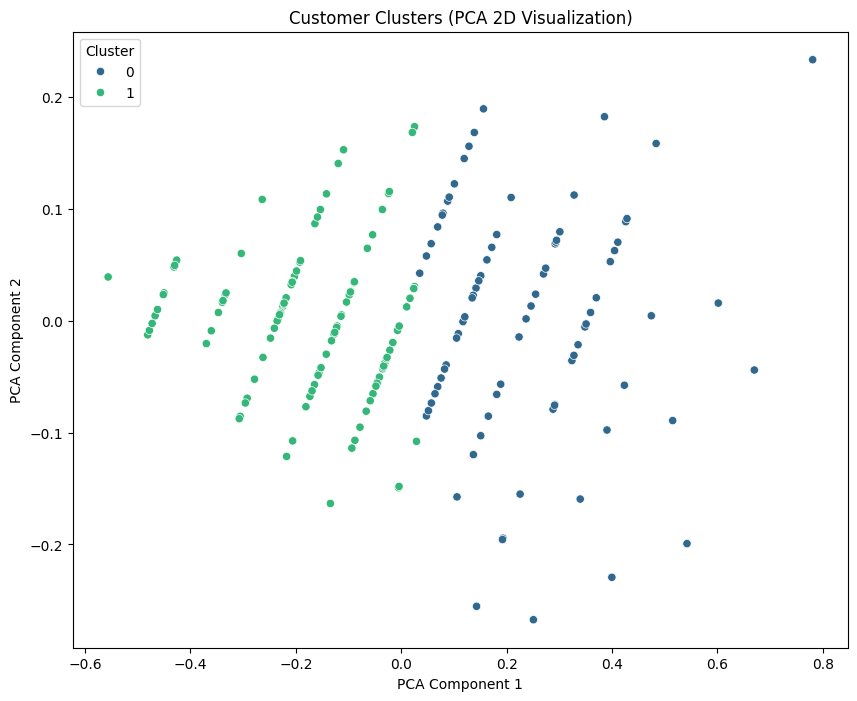

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_df)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=customer_data["Cluster"],
    palette="viridis",
    legend="full"
)
plt.title("Customer Clusters (PCA 2D Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


Step 5: Save Results


In [11]:
# Save cluster assignments to a CSV
customer_data[["CustomerID", "Cluster"]].to_csv("Customer_Clusters.csv", index=False)
print("Customer_Clusters.csv has been saved successfully!")


Customer_Clusters.csv has been saved successfully!


Compute Clustering Metrics

In [12]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(features_df, customer_data["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.2f}")

# Compute Silhouette Score
sil_score = silhouette_score(features_df, customer_data["Cluster"])
print(f"Silhouette Score: {sil_score:.2f}")


Davies-Bouldin Index: 0.85
Silhouette Score: 0.38
